# Feature Engineering - Pipeline Genérico

Este notebook implementa un pipeline completo de ingeniería de características usando `scikit-learn` ColumnTransformer.

**Funcionalidades:**
- Detección automática de tipos de características (numéricas, categóricas nominales, ordinales)
- Imputación automática de valores faltantes
- Codificación de variables categóricas (OneHotEncoder para nominales, OrdinalEncoder para ordinales)
- Creación de conjuntos de entrenamiento y evaluación
- Entrenamiento y evaluación de múltiples modelos supervisados
- Selección automática del mejor modelo según métricas de performance

## 1. Importar Librerías Necesarias

Importar todas las librerías requeridas para el pipeline de feature engineering.

In [2]:
import warnings
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Scikit-learn: Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split, cross_val_score

# Scikit-learn: Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Scikit-learn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

print("✅ Importaciones completadas exitosamente")

✅ Importaciones completadas exitosamente


## 2. Cargar y Explorar Dataset

Cargar el dataset desde el archivo de configuración.

In [3]:
# Cargar configuración
config_path = "../../config.json"
data_path = None

if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
        data_path = config.get('data_path', 'Base_de_datos.csv')
else:
    data_path = "../../Base_de_datos.csv"

# Cargar dataset
df = pd.read_csv(data_path)

print("="*80)
print("EXPLORACIÓN DEL DATASET")
print("="*80)
print(f"\n✓ Dataset cargado desde: {data_path}")
print(f"  Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
print(df.head())

print(f"\nTipos de datos:")
print(df.dtypes)

print(f"\nValores faltantes:")
print(df.isnull().sum())

EXPLORACIÓN DEL DATASET

✓ Dataset cargado desde: ../../alzheimers_disease_data.csv
  Dimensiones: 2149 filas × 35 columnas

Primeras filas:
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4      

## 3. Definir Tipos de Columnas

Detectar automáticamente y clasificar variables en: numéricas, categóricas nominales y ordinales.

In [9]:
print("\n" + "="*80)
print("CLASIFICACIÓN DE COLUMNAS")
print("="*80 + "\n")

# Excluir PatientID (identificador) y Diagnosis (target)
exclude_cols = ['PatientID', 'Diagnosis']
df_features = df[[col for col in df.columns if col not in exclude_cols]]

# Clasificar automáticamente
numeric_features = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_features.select_dtypes(include=['object']).columns.tolist()
ordinal_features = []

print(f"📊 Variables Numéricas ({len(numeric_features)}):")
print(f"   {numeric_features}\n")

print(f"📝 Variables Categóricas ({len(categorical_features)}):")
print(f"   {categorical_features}\n")

print(f"🏷️  Variables Nominales ({len(categorical_features)}):")
print(f"   {categorical_features}\n")

print(f"📈 Variables Ordinales ({len(ordinal_features)}):")
if ordinal_features:
    print(f"   {ordinal_features}\n")
else:
    print(f"   Ninguna\n")

print(f"Total de características (excluyendo target): {len(numeric_features) + len(categorical_features)}")


CLASIFICACIÓN DE COLUMNAS

📊 Variables Numéricas (32):
   ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']

📝 Variables Categóricas (1):
   ['DoctorInCharge']

🏷️  Variables Nominales (1):
   ['DoctorInCharge']

📈 Variables Ordinales (0):
   Ninguna

Total de características (excluyendo target): 33


## 4. Crear Pipelines de Preprocesamiento

Crear pipelines separados para cada tipo de característica.

In [10]:
print("\n" + "="*80)
print("CREACIÓN DE PIPELINES DE PREPROCESAMIENTO")
print("="*80 + "\n")

# Pipeline para variables numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
print("✓ Pipeline Numérico:")
print(f"    - SimpleImputer (estrategia: mediana)")
print(f"    - StandardScaler (normalización)")

# Pipeline para variables categóricas nominales
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
print("\n✓ Pipeline Categórico Nominal:")
print(f"    - SimpleImputer (estrategia: moda)")
print(f"    - OneHotEncoder (codificación binaria)")

# Pipeline para variables categóricas ordinales
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
print("\n✓ Pipeline Categórico Ordinal:")
print(f"    - SimpleImputer (estrategia: moda)")
print(f"    - OrdinalEncoder (codificación numérica)")


CREACIÓN DE PIPELINES DE PREPROCESAMIENTO

✓ Pipeline Numérico:
    - SimpleImputer (estrategia: mediana)
    - StandardScaler (normalización)

✓ Pipeline Categórico Nominal:
    - SimpleImputer (estrategia: moda)
    - OneHotEncoder (codificación binaria)

✓ Pipeline Categórico Ordinal:
    - SimpleImputer (estrategia: moda)
    - OrdinalEncoder (codificación numérica)


## 5. Construir ColumnTransformer

Combinar todos los pipelines en un ColumnTransformer unificado.

In [11]:
print("\n" + "="*80)
print("CONSTRUYENDO COLUMN TRANSFORMER")
print("="*80 + "\n")

# Crear lista de transformadores
transformers_list = []

# Agregar pipeline numérico
if numeric_features:
    transformers_list.append(('numeric', numeric_pipeline, numeric_features))
    print(f"✓ Agregando pipeline numérico para {len(numeric_features)} columnas")

# Agregar pipeline nominal (categóricas)
if categorical_features:
    transformers_list.append(('nominal', nominal_pipeline, categorical_features))
    print(f"✓ Agregando pipeline nominal para {len(categorical_features)} columnas")

# Crear ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='drop'
)

print(f"\n✓ ColumnTransformer creado exitosamente")
print(f"  Total de transformadores: {len(transformers_list)}")


CONSTRUYENDO COLUMN TRANSFORMER

✓ Agregando pipeline numérico para 32 columnas
✓ Agregando pipeline nominal para 1 columnas

✓ ColumnTransformer creado exitosamente
  Total de transformadores: 2


## 6. Aplicar Transformaciones al Dataset

Aplicar el ColumnTransformer para generar los datasets procesados.

In [12]:
print("\n" + "="*80)
print("APLICANDO TRANSFORMACIONES")
print("="*80 + "\n")

# Separar features (X) y target (y)
X = df_features.copy()
y = df['Diagnosis']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}\n")

# Aplicar transformaciones
print("📊 Transformando dataset...")
X_transformed = preprocessor.fit_transform(X)

print(f"✓ Dataset transformado: {X_transformed.shape}")
print(f"  Características originales: {X.shape[1]}")
print(f"  Características después de transformación: {X_transformed.shape[1]}")
print("\n✅ Transformaciones completadas exitosamente")


APLICANDO TRANSFORMACIONES

Features (X): (2149, 33)
Target (y): (2149,)

📊 Transformando dataset...
✓ Dataset transformado: (2149, 33)
  Características originales: 33
  Características después de transformación: 33

✅ Transformaciones completadas exitosamente


## 7. Dividir en Conjuntos de Entrenamiento y Evaluación

Crear train-test split para posterior entrenamiento y evaluación.

In [13]:
print("\n" + "="*80)
print("DIVIDIENDO EN TRAIN-TEST")
print("="*80 + "\n")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"✓ Dataset dividido en train-test (80-20)")
print(f"  Conjunto de entrenamiento: {X_train.shape[0]} muestras ({(X_train.shape[0]/len(y)*100):.1f}%)")
print(f"  Conjunto de evaluación: {X_test.shape[0]} muestras ({(X_test.shape[0]/len(y)*100):.1f}%)")
print(f"  Features por muestra: {X_train.shape[1]}")

# Verificar distribución de clases
print(f"\n📊 Distribución de clases en entrenamiento:")
print(pd.Series(y_train).value_counts())

print(f"\n📊 Distribución de clases en evaluación:")
print(pd.Series(y_test).value_counts())


DIVIDIENDO EN TRAIN-TEST

✓ Dataset dividido en train-test (80-20)
  Conjunto de entrenamiento: 1719 muestras (80.0%)
  Conjunto de evaluación: 430 muestras (20.0%)
  Features por muestra: 33

📊 Distribución de clases en entrenamiento:
0    1111
1     608
Name: Diagnosis, dtype: int64

📊 Distribución de clases en evaluación:
0    278
1    152
Name: Diagnosis, dtype: int64


## 8. Entrenar Múltiples Modelos

Entrenar varios modelos supervisados y evaluarlos.

In [14]:
print("\n" + "="*80)
print("ENTRENAMIENTO DE MODELOS")
print("="*80 + "\n")

# Definir modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Entrenar modelos
trained_models = {}
results = []

for model_name, model in models.items():
    print(f"📚 Entrenando {model_name}...")
    
    # Entrenar
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas de entrenamiento
    train_acc = accuracy_score(y_train, y_pred_train)
    
    # Métricas de evaluación
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    results.append({
        'Modelo': model_name,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })
    
    print(f"  ✓ Entrenamiento completado")

# Mostrar resultados
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("RESULTADOS DE EVALUACIÓN")
print("="*80)
print(results_df.to_string(index=False))


ENTRENAMIENTO DE MODELOS

📚 Entrenando Logistic Regression...
  ✓ Entrenamiento completado
📚 Entrenando Random Forest...
  ✓ Entrenamiento completado
📚 Entrenando Gradient Boosting...
  ✓ Entrenamiento completado
📚 Entrenando SVM...
  ✓ Entrenamiento completado
📚 Entrenando KNN...
  ✓ Entrenamiento completado

RESULTADOS DE EVALUACIÓN
             Modelo  Train Accuracy  Test Accuracy  Precision  Recall  F1-Score
Logistic Regression          0.8511         0.8163     0.8160  0.8163    0.8161
      Random Forest          1.0000         0.9419     0.9419  0.9419    0.9414
  Gradient Boosting          0.9680         0.9465     0.9464  0.9465    0.9465
                SVM          0.9389         0.8349     0.8329  0.8349    0.8331
                KNN          0.8237         0.7070     0.6949  0.7070    0.6902


## 9. Seleccionar Mejor Modelo


MEJOR MODELO SELECCIONADO

🏆 Modelo: Gradient Boosting
   F1-Score (Test): 0.9465
   Accuracy (Test): 0.9465



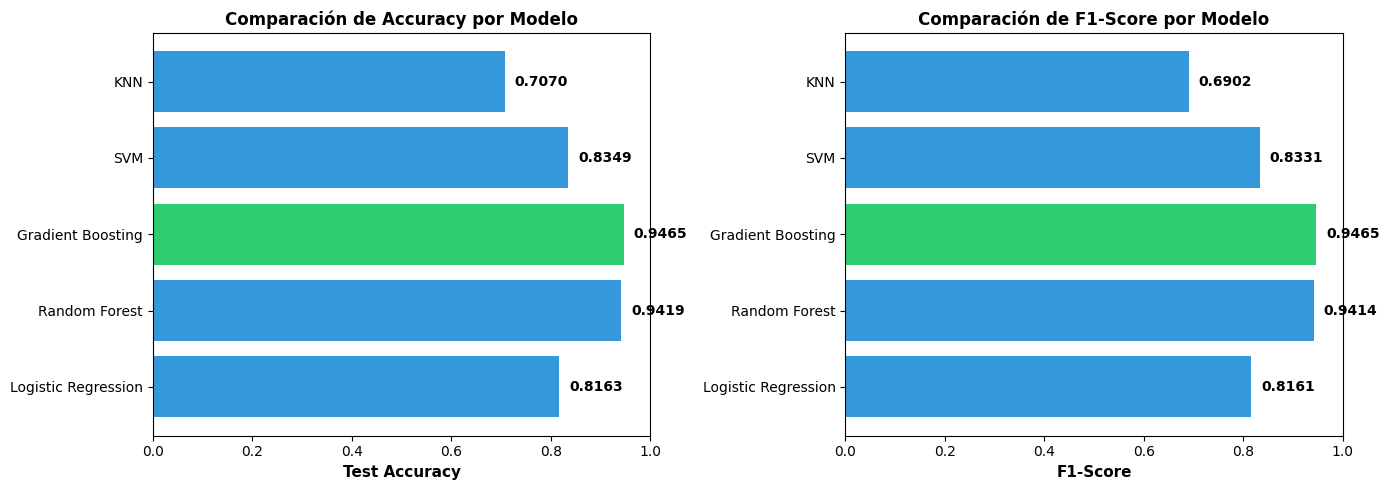


✅ Pipeline de Feature Engineering completado exitosamente.


In [15]:
# Seleccionar mejor modelo basado en F1-Score
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Modelo']
best_model = trained_models[best_model_name]
best_f1 = results_df['F1-Score'].max()
best_test_acc = results_df.loc[results_df['Modelo'] == best_model_name, 'Test Accuracy'].values[0]

print("\n" + "="*80)
print("MEJOR MODELO SELECCIONADO")
print("="*80)
print(f"\n🏆 Modelo: {best_model_name}")
print(f"   F1-Score (Test): {best_f1:.4f}")
print(f"   Accuracy (Test): {best_test_acc:.4f}\n")

# Visualizar comparación de modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparación de Accuracy
ax1 = axes[0]
models_names = results_df['Modelo']
test_acc_vals = results_df['Test Accuracy']
colors = ['#2ecc71' if name == best_model_name else '#3498db' for name in models_names]
ax1.barh(models_names, test_acc_vals, color=colors)
ax1.set_xlabel('Test Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Comparación de Accuracy por Modelo', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
for i, v in enumerate(test_acc_vals):
    ax1.text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold')

# Gráfico 2: Comparación de F1-Score
ax2 = axes[1]
f1_vals = results_df['F1-Score']
ax2.barh(models_names, f1_vals, color=colors)
ax2.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('Comparación de F1-Score por Modelo', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
for i, v in enumerate(f1_vals):
    ax2.text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Pipeline de Feature Engineering completado exitosamente.")

## 10. Funciones Auxiliares para Clasificación

Funciones reutilizables para procesos que se repiten (consistency y scalability).

In [16]:
def summarize_classification(y_true, y_pred, model_name, y_proba=None):
    """
    Función reutilizable para generar resumen de métricas de clasificación.
    
    Parámetros:
    -----------
    y_true : array-like
        Valores reales
    y_pred : array-like
        Predicciones del modelo
    model_name : str
        Nombre del modelo
    y_proba : array-like, optional
        Probabilidades predichas (para ROC-AUC en clasificación binaria)
    
    Retorna:
    --------
    dict : Diccionario con métricas de evaluación
    """
    from sklearn.metrics import confusion_matrix, classification_report
    
    metrics = {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    # Agregar ROC-AUC si es clasificación binaria y se proporcionan probabilidades
    if len(np.unique(y_true)) == 2 and y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba[:, 1])
    
    return metrics


def build_model(model_class, X_train, y_train, X_test, y_test, **kwargs):
    """
    Función reutilizable para entrenar y evaluar un modelo.
    
    Parámetros:
    -----------
    model_class : sklearn model class
        Clase del modelo a entrenar
    X_train, y_train : array-like
        Datos y etiquetas de entrenamiento
    X_test, y_test : array-like
        Datos y etiquetas de prueba
    **kwargs : dict
        Parámetros del modelo
    
    Retorna:
    --------
    tuple : (modelo entrenado, métricas_test, métricas_train)
    """
    # Crear e instanciar modelo
    model = model_class(**kwargs)
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilidades (si el modelo lo soporta)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test)
    
    # Generar métricas
    metrics_train = summarize_classification(y_train, y_pred_train, f"{model_class.__name__} (Train)")
    metrics_test = summarize_classification(y_test, y_pred_test, f"{model_class.__name__} (Test)", y_proba_test)
    
    return model, metrics_test, metrics_train

print("✅ Funciones auxiliares definidas: summarize_classification() y build_model()")

✅ Funciones auxiliares definidas: summarize_classification() y build_model()


## 11. Resumen Comparativo de Modelos Principales

Crear tabla resumen y gráficos comparativos para los modelos principales (mejores 3).


RESUMEN COMPARATIVO DE MODELOS PRINCIPALES

🏆 Top 3 Modelos por F1-Score:
   1. Gradient Boosting: F1=0.9465, Acc=0.9465
   2. Random Forest: F1=0.9414, Acc=0.9419
   3. SVM: F1=0.8331, Acc=0.8349

📊 TABLA RESUMEN - TOP 3 MODELOS:
 Rank            Modelo  Test Accuracy  Precision  Recall  F1-Score
    1 Gradient Boosting         0.9465     0.9464  0.9465    0.9465
    2     Random Forest         0.9419     0.9419  0.9419    0.9414
    3               SVM         0.8349     0.8329  0.8349    0.8331


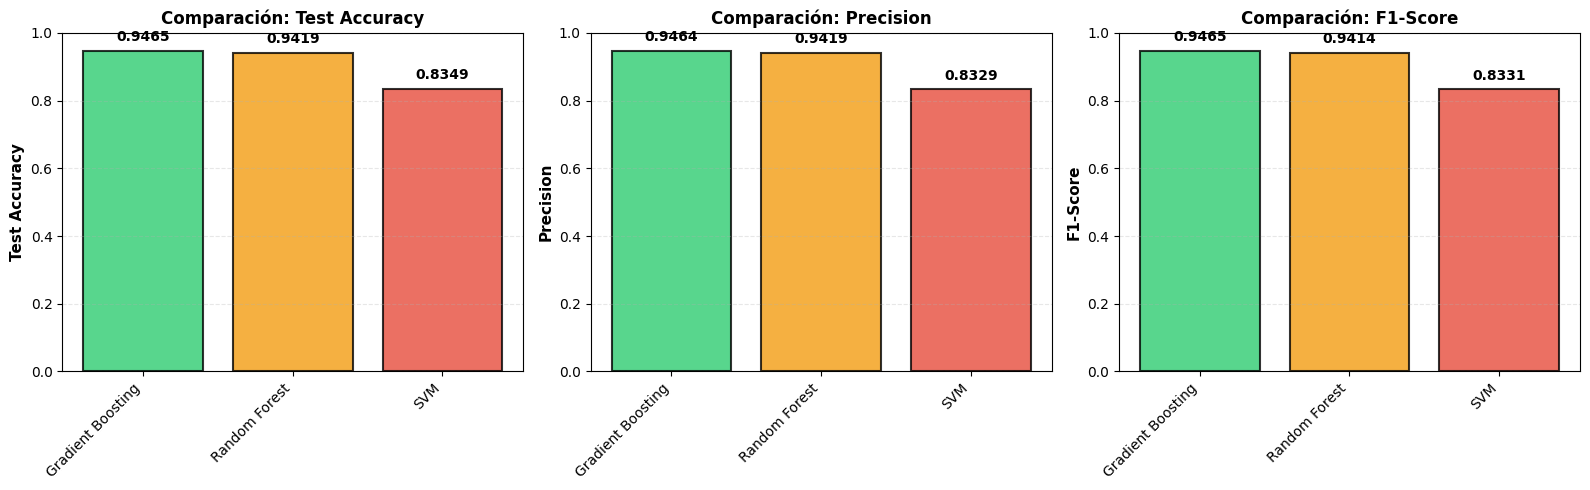


✅ Análisis comparativo completado.


In [17]:
print("\n" + "="*80)
print("RESUMEN COMPARATIVO DE MODELOS PRINCIPALES")
print("="*80 + "\n")

# Seleccionar top 3 modelos por F1-Score
top_3_indices = results_df.nlargest(3, 'F1-Score').index
top_3_models = results_df.loc[top_3_indices, 'Modelo'].tolist()

print(f"🏆 Top 3 Modelos por F1-Score:")
for i, model_name in enumerate(top_3_models, 1):
    f1_score_val = results_df.loc[results_df['Modelo'] == model_name, 'F1-Score'].values[0]
    acc_val = results_df.loc[results_df['Modelo'] == model_name, 'Test Accuracy'].values[0]
    print(f"   {i}. {model_name}: F1={f1_score_val:.4f}, Acc={acc_val:.4f}")

# Crear tabla resumen de modelos principales
top_3_summary = results_df.loc[top_3_indices, ['Modelo', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']].copy()
top_3_summary['Rank'] = range(1, len(top_3_summary) + 1)
top_3_summary = top_3_summary[['Rank', 'Modelo', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']]

print("\n📊 TABLA RESUMEN - TOP 3 MODELOS:")
print("="*80)
print(top_3_summary.to_string(index=False))
print("="*80)

# Crear visualización comparativa mejorada (3 métricas principales)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_to_plot = ['Test Accuracy', 'Precision', 'F1-Score']
colors_top3 = ['#2ecc71', '#f39c12', '#e74c3c']  # Verde, Naranja, Rojo

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    top_3_data = results_df.loc[top_3_indices]
    values = top_3_data[metric].values
    models = top_3_data['Modelo'].values
    
    bars = ax.bar(models, values, color=colors_top3, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'Comparación: {metric}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Agregar valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Rotar etiquetas si es necesario
    ax.set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✅ Análisis comparativo completado.")